## To be run from Delphes dir with conda env: py27

## File and Delphes class files are in "/scratch/Hammad/work/root"

## working flow:  

In [14]:
import sys, os
import ROOT
ROOT.gSystem.Load("libDelphes.so")
try:
    ROOT.gInterpreter.Declare('#include "/scratch/Hammad/work/Delphes-3.5.0/classes/DelphesClasses.h"')
    ROOT.gInterpreter.Declare('#include "/scratch/Hammad/work/Delphes-3.5.0/external/ExRootAnalysis/ExRootTreeReader.h"')
except:
    pass
from ROOT import TCanvas, TLorentzVector
#import pandas as pd
#import tensorflow as tf
#import root_numpy as rnp
import matplotlib.pyplot as plt
import numpy as np
import math
from tqdm import tqdm
#import emoji
import glob
import time as t
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import roc_curve
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout, Activation, Conv2D, MaxPooling2D
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from scipy.ndimage import gaussian_filter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import  label_binarize, LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
import sklearn
############ colors ##############
def Red(prt): print("\033[91m {}\033[00m" .format(prt))
def Green(prt): print("\033[92m {}\033[00m" .format(prt))
def Yellow(prt): print("\033[93m {}\033[00m" .format(prt))
#############################################
d = dict(file=sys.stdout,colour='green')
from matplotlib.font_manager import FontProperties
from matplotlib import colors
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["mathtext.default"] = "rm"
plt.rcParams['text.usetex'] = True
from matplotlib.colors import LogNorm
#plt.style.use('seaborn')
import matplotlib
import warnings
warnings.filterwarnings("ignore") #Ignore the outputed warnings

# Analysis class

In [2]:
class Analysis:
    
    def __init__(self,inputFile,NN):
        self.inputFile=inputFile
        self.NN = NN
        
        
    def flatten(slef,t):
        return [item for sublist in t for item in sublist]
    
    def phi_pi(slef,x):
        if (x > np.pi):  
            x= x -2*np.pi
        elif (x < -np.pi):
            x = x + 2*np.pi
        return x    

    def DeltaR(slef,x1,x2,y1,y2):
        return np.sqrt((x1-y1)**2+(x2-y2)**2)
    # Analysis in delphes to reconstruct the needed jets
    def Analysis_reco(self):
        chain= ROOT.TChain("Delphes")
        chain.Add(self.inputFile)
        # Create object of class ExRootTreeReader
        treeReader = ROOT.ExRootTreeReader(chain)
        Entries = treeReader.GetEntries()
        brancheflow = treeReader.UseBranch("eFlowChargedFilter")
        branchJet = treeReader.UseBranch("Jet")
        jet_reco_pt,jet_reco_eta,jet_reco_phi=[],[],[]
        dr,mH,ptH,etaH,phiH,dr1,pt_j=[],[],[],[],[],[],[]
        for entry in tqdm(range(0,self.NN),**d,desc ='Runing delphes analysis',ascii=True):
            treeReader.ReadEntry(entry)
            if (branchJet.GetEntries() <=1):continue
            wp =0    
            b =[jet for jet in branchJet if (jet.BTag & (1 << wp))]
            if (len(b) < 2):continue #at least two jets tagged as b-jets
            b1 = b[0]
            b2 = b[1]
            if (abs(b1.Eta)>2.5 or abs(b2.Eta)>2.5 or abs(b1.Phi)>np.pi or abs(b2.Phi)>np.pi): continue
            #for i  in range(len(b)):
            #    for j in range(len(b)):
            #        if i != j:
            #            m = (b[i].P4()+b[j].P4()).M()
            #            if(m > 110 and m < 140):
            #                idx = np.argsort([b[i].P4().Pt(),b[j].P4().Pt()])
            #                b1.append(b[idx[0]])
            #                b2.append(b[idx[1]])
            #            else:
            #                continue
            #if(len(b1) == 0 or len(b2)==0):continue                
            if (b1.P4()).Pt() < 40: continue
            if (b2.P4()).Pt() < 40: continue  
            dr.append(self.DeltaR(b1.Eta,b1.Phi,b2.Eta,b2.Phi)/2)
            etaH.append((b1.Eta+b2.Eta)/2)
            phiH.append((b1.Phi+b2.Phi)/2)
            ptH.append((b1.P4()+b2.P4()).Pt())
            mH.append((b1.P4()+b2.P4()).M())
        
            jet_reco_pt.append([jet.PT for jet in brancheflow if (jet.PT > 1 and abs(jet.Eta)<2.5 and abs(jet.Phi)<np.pi)])
            jet_reco_eta.append([jet.Eta for jet in brancheflow if (jet.PT > 1 and abs(jet.Eta)<2.5 and abs(jet.Phi)<np.pi)])
            jet_reco_phi.append([jet.Phi for jet in brancheflow if (jet.PT > 1 and abs(jet.Eta)<2.5 and abs(jet.Phi)<np.pi)])
        
        return jet_reco_pt,jet_reco_eta,jet_reco_phi,dr,etaH,phiH,ptH,mH
   
    
    # Function to center all objects in (\eta,\phi)=(eta(b1)+eta(b2)/2,phi(b1)+phi(b2)/2)
    # Note the rotation in phi plane is invariant so onjects > abs(2 pi) rotated back 
    def center(self):
        pt,eta,phi,r,eta1,phi1,_,_=self.Analysis_reco()
        pt_c,eta_c,phi_c=[],[],[]
        for i in tqdm(range(len(phi)),**d,desc ='Runing b-jets centering',ascii=True):
            phi_m = phi1[i]
            eta_m = eta1[i]
            phi_c.append([])
            eta_c.append([])
            pt_c.append([])
            for j in range(len(phi[i])):
                if phi[i][j]-phi_m < -np.pi:
                    phi_c[i].append(phi[i][j]-phi_m+2*np.pi)
                    eta_c[i].append(eta[i][j]-eta_m)
                    pt_c[i].append(pt[i][j]/np.array(pt[i]).max()) ##### Normalize the P_T
                elif phi[i][j]-phi_m  > np.pi:
                    phi_c[i].append(phi[i][j]-phi_m-2*np.pi)
                    eta_c[i].append(eta[i][j]-eta_m)
                    pt_c[i].append(pt[i][j]/np.array(pt[i]).max())    
                else:
                    phi_c[i].append(phi[i][j]-phi_m)        
                    eta_c[i].append(eta[i][j]-eta_m)
                    pt_c[i].append(pt[i][j]/np.array(pt[i]).max())    
                    
        return pt_c,eta_c,phi_c,r 
    
    # embed the recostructed objects in eta,phi,pt  image.
    # pixel size  = 0.1 of the eta and phi range 
    def make_image(self,etaedges,phiedges,sigma):
        pt,eta,phi,_=self.center()
        Image,xedges,yedges=[],[],[]
        for i in tqdm(range(len(pt)),**d,desc ='Runing make images',ascii=True):
            histo, x, y =  np.histogram2d(eta[i],phi[i],bins=(etaedges,phiedges),weights=np.array(pt[i]),normed=None)
            Image.append(gaussian_filter(histo,sigma,mode='nearest').T)
            xedges.append(x)
            yedges.append(y)
        return Image, xedges, yedges
    
    
    def make_image_Mollweide(self,etaedges,phiedges,sigma):
        pt,theta,phi=self.Riemann()
        Image,xedges,yedges=[],[],[]
        for i in tqdm(range(len(pt)),**d,desc ='Runing make Mollwiede images',ascii=True):
            histo, x, y =  np.histogram2d(phi[i],(np.arccos(np.array(theta[i]))-np.pi/2)*-1,bins=(etaedges,phiedges),weights=np.array(pt[i]),normed=None)  
            Image.append(gaussian_filter(histo,sigma,mode='nearest').T)
            xedges.append(x)
            yedges.append(y)
        return Image,xedges,yedges    
    
    def plot_mollweide(self,n,etaedges,phiedges,sigma):
        pt,theta,phi=self.Riemann()
        hist, lon, lat =  np.histogram2d(phi[n],(np.arccos(np.array(theta[n]))-np.pi/2)*-1,bins=(etaedges,phiedges),weights=np.array(pt[n]),normed=None)  
        plt.figure(figsize=(12,7))
        ax1=plt.subplot(221, projection="mollweide", facecolor='white')
        plt.setp(ax1.get_yticklabels(), visible=False);
        plt.setp(ax1.get_xticklabels(), visible=False);      
        fig1=plt.pcolor(lon, lat,hist.T,cmap='gist_heat_r', shading='auto',norm=LogNorm());
        plt.colorbar(fig1,shrink=0.5);
        plt.title('Mollweide image')
        plt.grid(c='k',linestyle='--');

        ax2=plt.subplot(222, projection="mollweide", facecolor='white')
        plt.setp(ax2.get_yticklabels(), visible=False);
        plt.setp(ax2.get_xticklabels(), visible=False);      
        fig2=plt.pcolor(lon, lat,gaussian_filter(hist,sigma,mode='nearest').T,cmap='gist_heat_r', shading='auto',norm=None);
        plt.colorbar(fig2,shrink=0.5);
        plt.title(r'Mollweide image (momentum smearing)')
        plt.grid(c='k',linestyle='--');
      
    
    def plot_normal(self,n,etaedges,phiedges):
        image1,x1,y1=self.make_image(etaedges,phiedges,0.00001)
        image2,x2,y2=self.make_image(etaedges,phiedges,3)
        plt.figure(figsize=(12,7))
        plt.subplot(221, projection=None)
        fig1=plt.pcolor(x1[n],y1[n],image1[n].T,cmap='gist_heat_r',norm=LogNorm());
        plt.colorbar(fig1,shrink=1);
        plt.title('Normal jet image');
        plt.xlabel(r'$\eta$',fontsize=20);
        plt.ylabel(r'$\phi$',fontsize=20);
        plt.grid(c='k',linestyle='--');
    
        plt.subplot(222, projection=None)
        fig2=plt.pcolor(x2[n],y2[n],image2[n].T,cmap='gist_heat_r',norm=None);
        plt.colorbar(fig2,shrink=1);
        plt.title(r'Normal image (momentum smearing)');
        plt.xlabel(r'$\eta$',fontsize=20);
        plt.ylabel(r'$\phi$',fontsize=20);
        plt.grid(c='k',linestyle='--');
        
    def plot_normal_Accu(self,n,etaedges,phiedges):
        pt,eta,phi,_=self.center()
        histo, xn, yn =  np.histogram2d(self.flatten(eta[:n]),self.flatten(phi[:n]),bins=(etaedges,phiedges),weights=self.flatten(np.array(pt[:n])),normed=None,density=True)
        
        plt.figure(figsize=(12,7))
        plt.subplot(221, projection=None)
        fig1=plt.pcolor(xn,yn,histo.T,cmap='jet',norm=LogNorm());
        plt.colorbar(fig1,shrink=1);
        plt.title('Normal jet image');
        plt.xlabel(r'$\eta$',fontsize=20);
        plt.ylabel(r'$\phi$',fontsize=20);
        plt.grid(c='k',linestyle='--');


In [5]:
bkg_file ='/SAS_HDD/ahammad/bkg/bkg_1/bkg1_1.root'
sig_file ='/scratch/Hammad/work/Delphes-3.5.0/signal_T.root'

In [10]:
#Create an instance of the analysis class to the signal and bkg events
signal=Analysis(sig_file,400000)
bkg=Analysis(bkg_file,400000)
etaedges = np.arange(-2.5,2.5+0.01,0.1)
phiedges = np.arange(-np.pi,np.pi+0.01,np.pi/25.)

# Display the constructed images 

Runing make images: 100%|#################| 1095/1095 [00:00<00:00, 4620.58it/s]


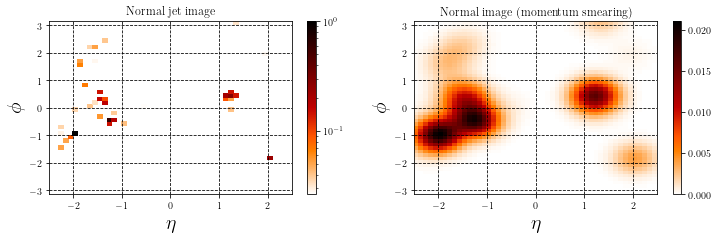

In [8]:
#Signal image-single shot
signal.plot_normal(1,etaedges,phiedges)

Runing make images: 100%|###################| 686/686 [00:00<00:00, 4465.72it/s]


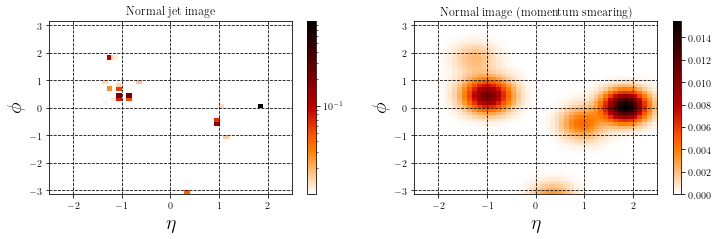

In [12]:
#Background image-single shot
bkg.plot_normal(3,etaedges,phiedges)

Runing b-jets centering: 100%|##########| 34698/34698 [00:06<00:00, 5005.16it/s]


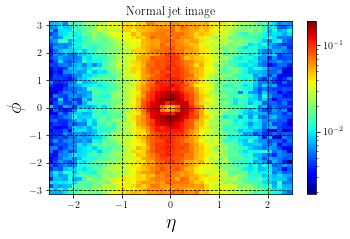

In [18]:
#Accumlated Average for the Signal images 
signal.plot_normal_Accu(20000,etaedges,phiedges)

Runing b-jets centering: 100%|##########| 23138/23138 [00:02<00:00, 7732.19it/s]


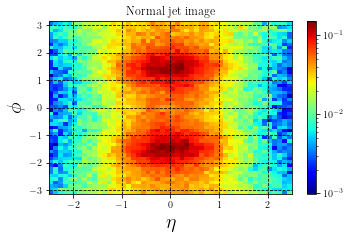

In [17]:
#Accumlated Average for the Signal images 
bkg.plot_normal_Accu(20000,etaedges,phiedges)

# Prepare inputs to the CNN

In [9]:
Image_sig,_,_ = signal.make_image(etaedges,phiedges,3)

Runing make images: 100%|#####################################################################| 139145/139145 [00:29<00:00, 4640.01it/s]


In [11]:
Image_bkg,_,_ = bkg.make_image(etaedges,phiedges,3)

Runing make images: 100%|#######################################################################| 92845/92845 [00:19<00:00, 4802.79it/s]


# save the constructed images for later use

In [12]:
outdir='/scratch/Hammad/work/data_Toponium'
np.savez_compressed(outdir+'Image_s', Image_sig);
np.savez_compressed(outdir+'Image_b', Image_bkg);

In [15]:
k=90000
x1_data = np.concatenate((Image_sig[:k], Image_bkg[:k]))
y1_data = np.array([1]*len(Image_sig[:k])+[0]*len(Image_bkg[:k]))
x_data,y_data= sklearn.utils.shuffle(x1_data, y1_data) # shuffle both 

In [16]:
X_train, X_test, y_train, y_test = train_test_split(x_data, y_data,shuffle=True, test_size=0.2)

In [10]:
# MinMax Scaler - If we do not normalize at the begining
scaler = MinMaxScaler()
X_train_norm,X_test_norm=[],[]
for i in tqdm(range(len(X_train)),**d,ascii=True):
    XR = scaler.fit_transform(X_train[i])
    X_train_norm.append(XR)
for j in tqdm(range(len(X_test)),**d,ascii=True):
    yR = scaler.transform(X_test[j])
    X_test_norm.append(yR)    

100%|##################################| 40000/40000 [00:02<00:00, 18291.88it/s]


In [17]:

#x_train=np.array(X_train_norm).reshape(np.array(X_train_norm).shape + (1,)).astype('float32')
#x_test= np.array(X_test_norm).reshape(np.array(X_test_norm).shape + (1,)).astype('float32')

x_train= np.array(X_train).reshape(np.array(X_train).shape+(1,)).astype('float32')
x_test= np.array(X_test).reshape(np.array(X_test).shape+(1,)).astype('float32')
x_train.shape,x_test.shape

((144000, 50, 50, 1), (36000, 50, 50, 1))

In [18]:
y_train = to_categorical(y_train, 2)
y_test = to_categorical(y_test, 2)

In [19]:
model_cnn = Sequential()
model_cnn.add(Conv2D(16, (3, 3), input_shape=(50, 50, 1),padding='same',  strides=1, activation='relu'))
model_cnn.add(Conv2D(16, (3, 3), padding='same',  strides=1,activation='relu'))
model_cnn.add(MaxPooling2D(pool_size=(2, 2)))
model_cnn.add(Dropout(0.25))

model_cnn.add(Conv2D(32, (3, 3), activation='relu'))
model_cnn.add(Conv2D(32, (3, 3),  activation='relu'))
model_cnn.add(MaxPooling2D(pool_size=(2, 2)))
model_cnn.add(Dropout(0.25))


model_cnn.add(Conv2D(64, (2, 2),  activation='relu'))
model_cnn.add(Conv2D(64, (2, 2), activation='relu'))
model_cnn.add(MaxPooling2D(pool_size=(2, 2)))
model_cnn.add(Dropout(0.25))


model_cnn.add(Flatten())
model_cnn.add(Dense(128, activation='relu'))
model_cnn.add(Dropout(0.2))
model_cnn.add(Dense(2, activation='softmax'))
model_cnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 50, 50, 16)        160       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 50, 50, 16)        2320      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 25, 25, 16)        0         
_________________________________________________________________
dropout (Dropout)            (None, 25, 25, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 23, 23, 32)        4640      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 21, 21, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 10, 10, 32)        0

2022-10-30 11:39:19.840454: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-30 11:39:20.910962: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38246 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:b1:00.0, compute capability: 8.0
2022-10-30 11:39:20.912999: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 38246 MB memory:  -> device: 1, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:d9:00.0, compute capability: 8.0


In [20]:
model_cnn.compile(loss='categorical_crossentropy',optimizer=tf.keras.optimizers.Adam(learning_rate=5e-04), metrics=['accuracy'])
history_cnn = model_cnn.fit(x_train, y_train, validation_split=0.2, epochs=20, batch_size=50,shuffle=True, verbose=1)


Epoch 1/20
2304/2304 [==============================] - 13s 4ms/step - loss: 0.5899 - accuracy: 0.6831 - val_loss: 0.5421 - val_accuracy: 0.7257
Epoch 2/20
2304/2304 [==============================] - 9s 4ms/step - loss: 0.5327 - accuracy: 0.7344 - val_loss: 0.5276 - val_accuracy: 0.7300
Epoch 3/20
2304/2304 [==============================] - 9s 4ms/step - loss: 0.4781 - accuracy: 0.7689 - val_loss: 0.4382 - val_accuracy: 0.7938
Epoch 4/20
2304/2304 [==============================] - 9s 4ms/step - loss: 0.4460 - accuracy: 0.7877 - val_loss: 0.4549 - val_accuracy: 0.7798
Epoch 5/20
2304/2304 [==============================] - 9s 4ms/step - loss: 0.4360 - accuracy: 0.7942 - val_loss: 0.4264 - val_accuracy: 0.7982
Epoch 6/20
2304/2304 [==============================] - 9s 4ms/step - loss: 0.4263 - accuracy: 0.8000 - val_loss: 0.4249 - val_accuracy: 0.7986
Epoch 7/20
2304/2304 [==============================] - 9s 4ms/step - loss: 0.4206 - accuracy: 0.8037 - val_loss: 0.4008 - val_accuracy

2022-10-30 11:39:40.427441: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-10-30 11:39:41.971451: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8302
2022-10-30 11:39:43.042076: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-10-30 11:39:43.120014: I tensorflow/stream_executor/cuda/cuda_blas.cc:1760] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


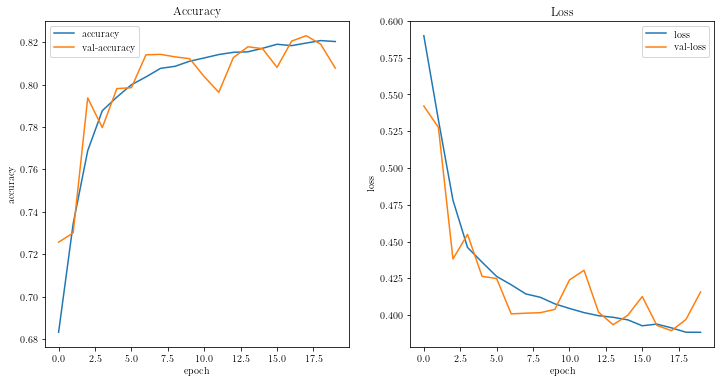

In [21]:
# summarize history for accuracy
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.plot(history_cnn.history['accuracy'],label='accuracy')
plt.plot(history_cnn.history['val_accuracy'],label='val-accuracy')
plt.title('Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(loc='best')
plt.subplot(1,2,2)
# summarize history for loss
plt.plot(history_cnn.history['loss'],label='loss')
plt.plot(history_cnn.history['val_loss'],label='val-loss')
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='best')
plt.show()

In [22]:
scores = model_cnn.evaluate(x_test, y_test, verbose=0)
print("%s: %.2f%%" % (model_cnn.metrics_names[1], scores[1]*100))

accuracy: 80.77%


In [23]:
score=model_cnn.predict(x_test);
fpr, tpr, thresholds =roc_curve(y_test.ravel(),score.ravel());

In [24]:
from sklearn.metrics import auc
auc = auc(fpr, tpr)

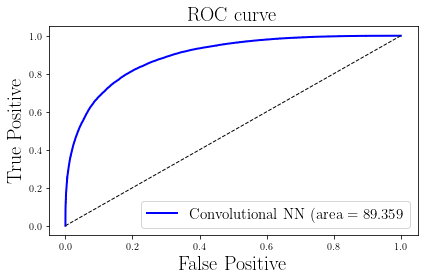

In [32]:
plt.plot(fpr,tpr,linewidth=2,color='b',label='Convolutional NN (area = {:.3f}%)'.format(auc*100));
plt.plot([0,1],[0,1],'k--',linewidth=1);
plt.xlabel('False Positive',fontsize=20);
plt.ylabel('True Positive',fontsize=20);
plt.title('ROC curve',fontsize=20)
#plt.xlim(0,1);
#plt.ylim(0,1);
plt.tight_layout()
plt.legend(fontsize=15);

In [26]:
def predict_prob(number):
    return [number[0],number[1]]

y_prob = np.array(list(map(predict_prob, model_cnn.predict(x_test))))

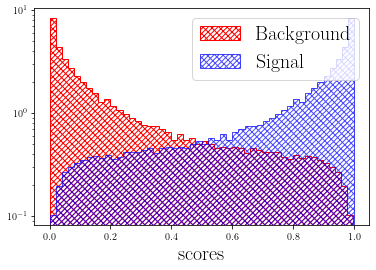

In [44]:
plt.hist(np.array(y_prob[y_test==0]),histtype='step',fill=False,color='r',bins=50,alpha=1,label='Background',density=True,hatch='\\\\\/////');
plt.hist(np.array(1-y_prob[y_test==0]),histtype='step',fill=False,color='b',bins=50,alpha=0.7,label='Signal',density=True,hatch='\\\\\/////');
plt.yscale('log');
#plt.xlim(0.9,1.01);
plt.xlabel('scores',fontsize=20);
plt.legend(loc='best',fontsize=20);

# To be done: Hyberparameters optimization 

In [ ]:
def build_classifier(lr=0.001,n1=30,n2=30,n3=30,n4=30,n5=30,n6=30,k1=(2,2),k2=(2,2),k3=(2,2),k4=(2,2),k5=(2,2),k6=(2,2)):
    classifier = Sequential()
    
    classifier.add(Conv2D(n1, k1, input_shape=(50, 50, 1),padding='same',  strides=1, activation='relu'))
    classifier.add(Conv2D(n2, k2, padding='same',  strides=1,activation='relu'))
    classifier.add(MaxPooling2D(pool_size=(2, 2)))
    classifier.add(Dropout(0.25))

    classifier.add(Conv2D(n3, k3, padding='same',  strides=1,activation='relu'))
    classifier.add(Conv2D(n4, k4, padding='same',strides=1, activation='relu'))
    classifier.add(MaxPooling2D(pool_size=(2, 2)))
    classifier.add(Dropout(0.25))


    classifier.add(Conv2D(n5, k5, padding='same',  strides=1, activation='relu'))
    classifier.add(Conv2D(n6, k6, padding='same',  strides=1,activation='relu'))
    classifier.add(MaxPooling2D(pool_size=(2, 2)))
    classifier.add(Dropout(0.25))



    classifier.add(Flatten())
    classifier.add(Dense(256, activation='relu'))
    classifier.add(Dropout(0.5))
    classifier.add(Dense(128, activation='relu'))
    classifier.add(Dropout(0.5))
    classifier.add(Dense(2, activation='softmax'))
 
    classifier.compile(loss='categorical_crossentropy',optimizer=tf.keras.optimizers.Adam(learning_rate=lr), metrics=['accuracy'])
 
    return classifier

In [ ]:
classifier = KerasClassifier(build_fn = build_classifier)

In [ ]:
grid_searchR = RandomizedSearchCV(classifier, parameters, cv=10,n_iter=50)

In [ ]:
with strategy.scope():
    classifier_GSR = grid_searchR.fit(xR_train, yR_train,validation_split=0.2,verbose=0)

In [ ]:
# summarize result
print('Best Score: %s' % classifier_GSR.best_score_)
print('Best Hyperparameters: %s' % classifier_GSR.best_params_)